# Proyecto 5 — Transformers con IMDB




## 0) Preparación e instalación de librerías

In [1]:
# --- Solo para ESTE notebook: forzar Transformers a NO usar TensorFlow ---
import os
os.environ["TRANSFORMERS_NO_TF"] = "1"
os.environ["USE_TF"] = "0"

# Comprobación opcional:
from transformers.utils import is_tf_available


## 1) Imports y carpetas de trabajo

In [2]:
import os, time, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from datasets import load_dataset
from transformers import BertTokenizerFast, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# Carpetas para guardar resultados
os.makedirs("../results/5_transformer", exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)

Usando dispositivo: cpu


## 2) Dataset (IMDB) — subset chico

In [3]:
# Cargamos IMDB y usamos un subset pequeño para que corra rápido en cualquier PC
dataset = load_dataset("imdb")

tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=256)

tokenized = dataset.map(tokenize, batched=True)
tokenized = tokenized.rename_column("label", "labels")
tokenized.set_format("torch", columns=["input_ids","attention_mask","labels"])

# Subsets (ajusta números si tu PC lo permite)
train_ds = tokenized["train"].shuffle(seed=42).select(range(5000))   # 5k train
test_ds  = tokenized["test"].shuffle(seed=42).select(range(2000))    # 2k test

len(train_ds), len(test_ds)

(5000, 2000)

## 3) Modelo (BERT base)

In [4]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2).to(device)
params_count = model.num_parameters()
print("Parámetros del modelo:", params_count)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Parámetros del modelo: 109483778


## 4) Métricas

In [5]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    acc = accuracy_score(labels, preds)
    f1  = f1_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

## 5) Entrenamiento

Epoch 1/2 - loss: 0.3789
Epoch 2/2 - loss: 0.1773
Tiempo total de entrenamiento (s): 14358.2
Guardado: ../results/5_transformer/training_loss.png
Métricas de evaluación (manual): {'eval_accuracy': 0.905, 'eval_f1': 0.9050949050949051, 'eval_loss': 0.23954238467628047}
Guardado: ../results/5_transformer/confusion_matrix.png
Guardado: ../results/5_transformer/examples.csv


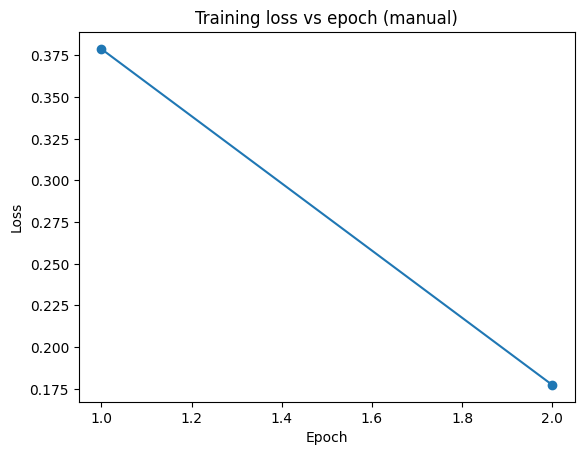

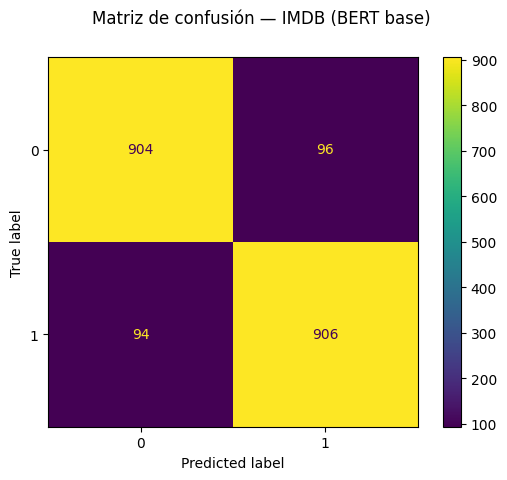

In [6]:
# === Entrenamiento manual (sin Trainer / sin accelerate) ===
from torch.utils.data import DataLoader
import torch
from torch.optim import AdamW

epochs = 2
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
eval_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False)

optimizer = AdamW(model.parameters(), lr=2e-5)

model.train()
t0 = time.time()
train_losses = []
for epoch in range(epochs):
    running_loss = 0.0
    for batch in train_loader:
        optimizer.zero_grad()
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    train_losses.append((epoch+1, epoch_loss))
    print(f"Epoch {epoch+1}/{epochs} - loss: {epoch_loss:.4f}")
t1 = time.time()
train_time_sec = round(t1 - t0, 1)
print("Tiempo total de entrenamiento (s):", train_time_sec)

# Guardar curva de training loss
import matplotlib.pyplot as plt
plt.figure()
xs = [e for e, _ in train_losses]
ys = [l for _, l in train_losses]
plt.plot(xs, ys, marker='o')
plt.title("Training loss vs epoch (manual)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
tr_path = "../results/5_transformer/training_loss.png"
plt.savefig(tr_path, bbox_inches="tight")
print("Guardado:", tr_path)

# === Evaluación manual ===
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
model.eval()
all_preds, all_labels = [], []
eval_losses = []
with torch.no_grad():
    for batch in eval_loader:
        labels = batch["labels"].numpy()
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits.detach().cpu().numpy()
        loss = outputs.loss.item()
        eval_losses.append(loss)
        preds = logits.argmax(axis=1)
        all_preds.extend(preds.tolist())
        all_labels.extend(labels.tolist())

acc = accuracy_score(all_labels, all_preds)
f1  = f1_score(all_labels, all_preds)
eval_loss = float(sum(eval_losses) / len(eval_losses)) if eval_losses else None
metrics = {"eval_accuracy": acc, "eval_f1": f1, "eval_loss": eval_loss}
print("Métricas de evaluación (manual):", metrics)

# Matriz de confusión
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(cm)
fig = disp.plot().figure_
fig.suptitle("Matriz de confusión — IMDB (BERT base)")
cm_path = "../results/5_transformer/confusion_matrix.png"
fig.savefig(cm_path, bbox_inches="tight")
print("Guardado:", cm_path)

# Preparar dataframe de predicciones para ejemplos
import pandas as pd
from datasets import load_dataset
df_preds = pd.DataFrame({
    "text": [t for t in load_dataset("imdb")["test"]["text"][:len(all_preds)]],
    "true": all_labels,
    "pred": all_preds
})
ex_path = "../results/5_transformer/examples.csv"
df_preds.to_csv(ex_path, index=False, encoding="utf-8")
print("Guardado:", ex_path)


## 6) Evaluación y matriz de confusión

In [7]:
print("Métricas:", metrics)

Métricas: {'eval_accuracy': 0.905, 'eval_f1': 0.9050949050949051, 'eval_loss': 0.23954238467628047}


## 7) Curvas de aprendizaje (loss vs epoch)

Guardado: ../results/5_transformer/eval_loss.png


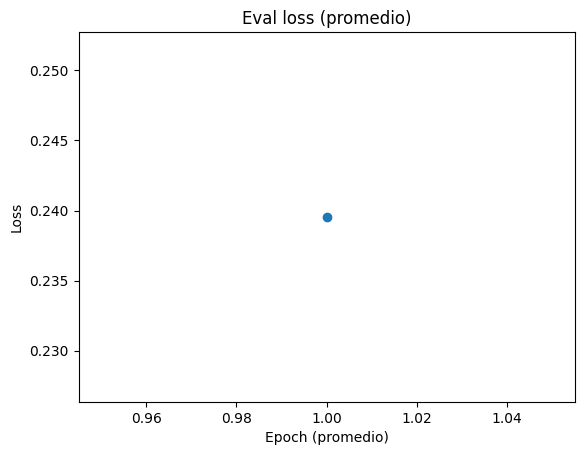

In [8]:
# Curvas ya guardadas en ../results/5_transformer/training_loss.png (arriba)
import matplotlib.pyplot as plt
if metrics.get("eval_loss") is not None:
    plt.figure()
    plt.plot([1], [metrics["eval_loss"]], marker='o')
    plt.title("Eval loss (promedio)")
    plt.xlabel("Epoch (promedio)")
    plt.ylabel("Loss")
    ev_path = "../results/5_transformer/eval_loss.png"
    plt.savefig(ev_path, bbox_inches="tight")
    print("Guardado:", ev_path)
    plt.show()
else:
    print("No se calculó eval_loss por epoch (solo promedio).")

## 8) Ejemplos correctos e incorrectos

In [13]:
y_pred = all_preds
y_true = all_labels

df_preds = pd.DataFrame({
    "text": [t for t in load_dataset("imdb")["test"]["text"][:len(y_pred)]],
    "true": y_true,
    "pred": y_pred
})


correctos = df_preds[df_preds.true==df_preds.pred].head(5)
incorrectos = df_preds[df_preds.true!=df_preds.pred].head(5)

print("Ejemplos correctos (primeros 5):")
display(correctos[["text","true","pred"]])

print("\nEjemplos incorrectos (primeros 5):")
display(incorrectos[["text","true","pred"]])

# Guardar a CSV
ex_path = "../results/5_transformer/examples.csv"
df_preds.to_csv(ex_path, index=False, encoding="utf-8")
print("Guardado:", ex_path)

Ejemplos correctos (primeros 5):


,text,true,pred
0,I love sci-fi and am willing to put up with a ...,1,1
1,"Worth the entertainment value of a rental, esp...",1,1
2,its a totally average film with a few semi-alr...,0,0
3,STAR RATING: ***** Saturday Night **** Friday ...,1,1
4,"First off let me say, If you haven't enjoyed a...",0,0



Ejemplos incorrectos (primeros 5):


,text,true,pred
21,Dr Stephens (Micheal Harvey) runs a mental asy...,0,1
34,"I quite enjoyed The Wrecking Crew (1999), whic...",0,1
46,"Okay, so it was never going to change the worl...",1,0
51,An obscure horror show filmed in the Everglade...,1,0
59,Witchy Hildegard Knef traps a group of people ...,1,0


Guardado: ../results/5_transformer/examples.csv


## 9) Guardar métricas y actualizar summary.csv

In [14]:
# Guardar métricas detalladas
metrics_full = {
    "accuracy": float(metrics.get("eval_accuracy", 0.0)),
    "f1": float(metrics.get("eval_f1", 0.0)),
    "loss": float(metrics.get("eval_loss", 0.0)),
    "epochs": 2,
    "params": int(params_count),
    "train_time_sec": float(train_time_sec)
}

metrics_path = "../results/5_transformer/metrics.json"
with open(metrics_path, "w", encoding="utf-8") as f:
    json.dump(metrics_full, f, ensure_ascii=False, indent=2)
print("Guardado:", metrics_path)

# Agregar/actualizar summary.csv
summary_path = "../results/summary.csv"
row = {
    "task": "Transformer-IMDB",
    "model_name": "bert-base-uncased",
    "accuracy": metrics_full["accuracy"],
    "f1": metrics_full["f1"],
    "loss": metrics_full["loss"],
    "epochs": metrics_full["epochs"],
    "params": metrics_full["params"],
    "train_time_sec": metrics_full["train_time_sec"],
    "notes": "Fine-tune en subset IMDB (5000 train / 2000 test)"
}

if os.path.exists(summary_path):
    df = pd.read_csv(summary_path)
    df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)
else:
    df = pd.DataFrame([row])

df.to_csv(summary_path, index=False, encoding="utf-8")
print("Actualizado:", summary_path)
df.tail(5)

Guardado: ../results/5_transformer/metrics.json
Actualizado: ../results/summary.csv


,model_name,notebook_name,test_accuracy,f1,test_loss,epochs,model_params,training_time,final_g_loss,final_d_loss,...,final_val_accuracy,final_training_loss,final_val_loss,timestamp,task,accuracy,loss,params,train_time_sec,notes
1,dcgan_celeba_64,2_dcgan_generation,NaN,NaN,7.941555,5.0,6342272.0,1725.872513,7.941555,0.604401,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,lstm_imdb_tuned,4_lstm_text_imdb,NaN,NaN,NaN,NaN,2732993.0,NaN,NaN,NaN,...,0.8736,0.227659,0.311605,2025-10-05T19:14:40.008374,NaN,NaN,NaN,NaN,NaN,NaN
3,MiniLM + Annoy + roberta-base-squad2,NaN,NaN,0.870587,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,RAG-QA,0.720,NaN,"{""retriever"": ""Annoy(angular)"", ""reader"": ""rob...",NaN,RAG simple con Annoy (SQuAD subset); ejemplos ...
4,bert-base-uncased,NaN,NaN,0.905095,NaN,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Transformer-IMDB,0.905,0.239542,109483778,14358.2,Fine-tune en subset IMDB (5000 train / 2000 test)
5,bert-base-uncased,NaN,NaN,0.905095,NaN,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Transformer-IMDB,0.905,0.239542,109483778,14358.2,Fine-tune en subset IMDB (5000 train / 2000 test)
